In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading 

In [3]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "drive/MyDrive/CACM/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [4]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [8]:
X_test.shape

(5751, 32, 36)

In [38]:
X_train.shape

(22625, 32, 36)

In [11]:
# X = X_train[:,0,:]
# data = pd.DataFrame(X)
# data_nan = data.replace(0,np.nan)
# X_trian = data_nan.dropna()

### Extract the most missed value

In [39]:
sample_count , frames, dimension = X_train.shape

In [40]:
X_train_numpy = np.array(X_train)
missedData = np.zeros(dimension)
for j in range(dimension):
  missedValue_count = 0
  for i in range(sample_count):
    cnt_array = np.where(X_train_numpy[i,:,j],0,1)
    missedValue_count = np.sum(cnt_array) + missedValue_count
  missedData[j] = missedValue_count


In [41]:
missed_value_index = np.argsort(missedData)
missed_value_index

array([ 2,  3, 23, 22, 17, 16,  4,  5, 10, 11, 19, 18, 25, 24, 27, 26, 20,
       21,  7,  6, 12, 13,  9,  8, 15, 14, 32, 33, 35, 34,  1,  0, 29, 28,
       30, 31])

Text(0, 0.5, 'count')

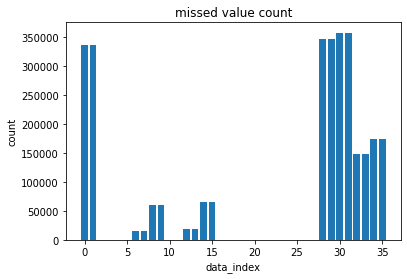

In [42]:
numBins = np.arange(0,36,1)
plt.title('missed value count')
plt.bar(numBins, missedData, width=0.8)
plt.xlabel('data_index')
plt.ylabel('count')


In [20]:
value_count = sample_count *  frames - missedData
value_count

array([387602., 387602., 723922., 723922., 723893., 723893., 708668.,
       708668., 664009., 664009., 723889., 723889., 704853., 704853.,
       657926., 657926., 723903., 723903., 723813., 723813., 723654.,
       723654., 723908., 723908., 723791., 723791., 723658., 723658.,
       378102., 378102., 367038., 367038., 575713., 575713., 550487.,
       550487.])

### Pre-Process 

In [43]:
import torch
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([5751, 32, 36])
test_label_size: torch.Size([5751, 1])
n_data_size_test: 5751
train_data_size: torch.Size([22625, 32, 36])
train_label_size: torch.Size([22625, 1])
n_data_size_train: 22625


In [44]:
import torch.nn as nn
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [45]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(32)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [46]:
n_hidden = 128
n_joints = 18*2
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(36, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [47]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

### Getting Random Data 

In [48]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [51]:
try:
   rnn.load_state_dict(torch.load('drive/MyDrive/CACM/models/lstm_6_bn.pth'))
except:
   print('no pkl')

In [54]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 6s) 0.0029  / WAVING_2HANDS ✓
2000 2% (0m 12s) 0.0003  / WAVING_1HAND ✓
3000 3% (0m 18s) 0.0011  / WAVING_1HAND ✓
4000 4% (0m 24s) 0.0008  / BOXING ✓
5000 5% (0m 30s) 0.0036  / CLAPPING_HANDS ✓
6000 6% (0m 36s) 0.0407  / BOXING ✓
7000 7% (0m 43s) 0.0147  / CLAPPING_HANDS ✓
8000 8% (0m 49s) 0.0012  / JUMPING_JACKS ✓
9000 9% (0m 55s) 0.0007  / WAVING_2HANDS ✓
10000 10% (1m 1s) 0.0007  / BOXING ✓
11000 11% (1m 7s) 0.0091  / JUMPING ✓
12000 12% (1m 13s) 0.0002  / WAVING_1HAND ✓
13000 13% (1m 19s) 0.0035  / CLAPPING_HANDS ✓
14000 14% (1m 26s) 0.0004  / WAVING_1HAND ✓
15000 15% (1m 32s) 0.0012  / JUMPING ✓
16000 16% (1m 38s) 0.0007  / WAVING_1HAND ✓
17000 17% (1m 44s) 0.0081  / BOXING ✓
18000 18% (1m 50s) 0.0006  / JUMPING ✓
19000 19% (1m 56s) 0.0002  / WAVING_1HAND ✓
20000 20% (2m 3s) 0.0024  / JUMPING ✓
21000 21% (2m 9s) 0.0304  / BOXING ✓
22000 22% (2m 15s) 0.0008  / JUMPING_JACKS ✓
23000 23% (2m 21s) 0.0006  / WAVING_1HAND ✓
24000 24% (2m 27s) 0.0068  / JUMPING_JACKS ✓
25000 

In [55]:
# torch.save(rnn.state_dict(),'drive/MyDrive/CACM/models/lstm_6_bn.pth')

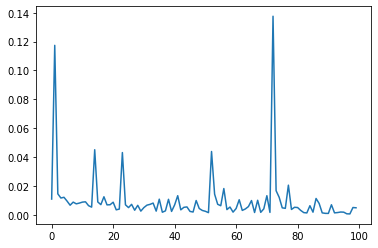

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing

In [57]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print(flag,'accuracy',right/n)
    return right/n

In [58]:
test('test')

test accuracy 0.9768735872022257


0.9768735872022257

In [59]:
test('train')

train accuracy 0.9878011049723757


0.9878011049723757

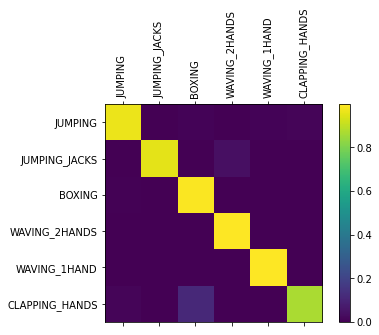

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [61]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from IPython.display import display


# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

COMPUTE_LSTM_IMPORTANCE = 1


COLS = dimension

with gpu_strategy.scope():
    # 计算特征重要性
    if COMPUTE_LSTM_IMPORTANCE:
        results = []
        print(' Computing LSTM feature importance...')

        # for k in tqdm(range(len(COLS))):
        for k in tqdm(range(COLS)):
            if k>0: 
                temp = tensor_X_test.numpy()
                save_col = temp[:,:,k-1].copy()
                np.random.shuffle(temp[:,:,k-1])
                
                tensor_X_test = torch.from_numpy(temp)

            mae = test('test')
            # print(mae)
            results.append({'feature':k,'mae':mae})
    
            if k>0: 
                temp[:,:,k-1] = save_col
                tensor_X_test = torch.from_numpy(temp)
      

 Computing LSTM feature importance...


  0%|          | 0/36 [00:00<?, ?it/s]

test accuracy 0.9768735872022257
test accuracy 0.9123630672926447
test accuracy 0.9507911667536081
test accuracy 0.9756564075812902
test accuracy 0.9746131107633456
test accuracy 0.9744392279603548
test accuracy 0.9730481655364285
test accuracy 0.952529994783516
test accuracy 0.819509650495566
test accuracy 0.8570683359415754
test accuracy 0.7197009215788559
test accuracy 0.9780907668231612
test accuracy 0.9735698139454008
test accuracy 0.9674839158407234
test accuracy 0.8939314901756217
test accuracy 0.8447226569292297
test accuracy 0.5884194053208138
test accuracy 0.9737436967483916
test accuracy 0.974960876369327
test accuracy 0.9563554164493132
test accuracy 0.975830290384281
test accuracy 0.9088854112328291
test accuracy 0.9707876890975482
test accuracy 0.9761780559902625
test accuracy 0.9737436967483916
test accuracy 0.965397322204834
test accuracy 0.9744392279603548
test accuracy 0.9462702138758476
test accuracy 0.9640062597809077
test accuracy 0.9349678316814467
test accuracy 0

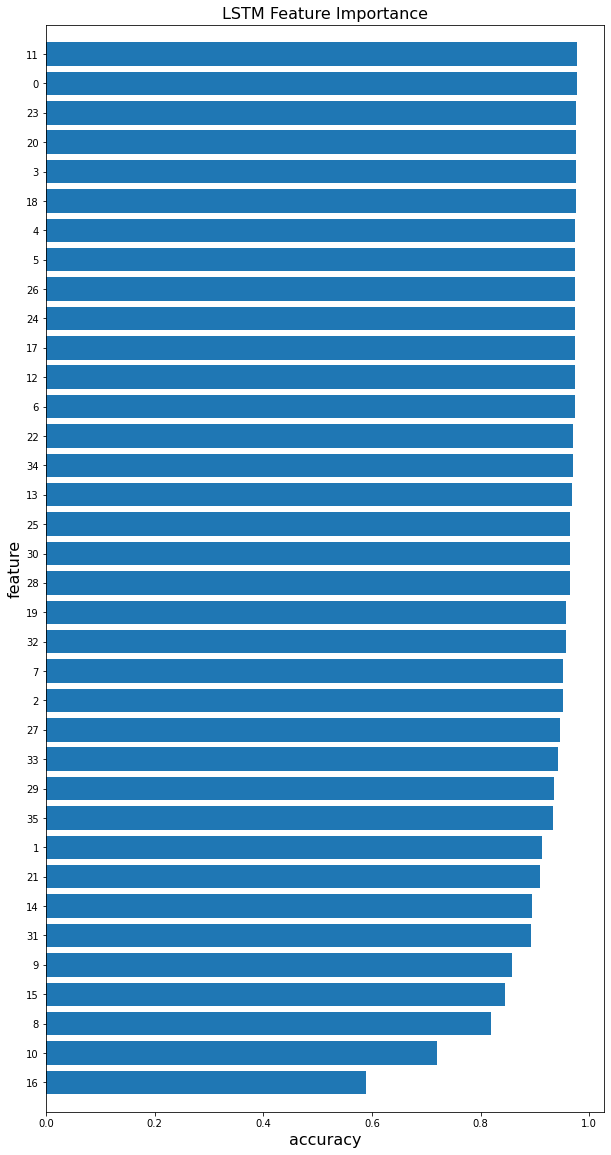

In [62]:
# 展示特征重要性
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,20))
plt.barh(np.arange(COLS),df.mae,height = 0.8)
plt.yticks(np.arange(COLS),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,COLS))
plt.xlabel('accuracy',size = 16)
plt.ylabel('feature',size = 16)
# for a,b in zip(np.arange(COLS),df.mae):

#   plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=7)
plt.show()

In [63]:
relatvie_effect = np.zeros(36)
for i in range(dimension):
  relatvie_effect[i] = (1 - results[i]['mae'])/value_count[i] * sample_count *  frames
  

In [64]:
relatvie_effect

array([0.04319772, 0.16369663, 0.04921414, 0.02434622, 0.02539064,
       0.02556455, 0.02753494, 0.04849702, 0.19679705, 0.15584506,
       0.28034206, 0.02191259, 0.02714815, 0.03339937, 0.11672073,
       0.17087149, 0.41163574, 0.02625982, 0.02504559, 0.04365586,
       0.02418127, 0.09115815, 0.02921602, 0.02382497, 0.02626388,
       0.03461267, 0.02557285, 0.05375518, 0.06892179, 0.12452537,
       0.06928441, 0.21265513, 0.05488616, 0.07216109, 0.03910608,
       0.0866737 ])

In [65]:
relatvie_effect_order = np.argsort(relatvie_effect)[::-1]
relatvie_effect_order

array([16, 10, 31,  8, 15,  1,  9, 29, 14, 21, 35, 33, 30, 28, 32, 27,  2,
        7, 19,  0, 34, 25, 13, 22,  6, 12, 24, 17, 26,  5,  4, 18,  3, 20,
       23, 11])

In [ ]:
df.to_csv(f'lstm_feature_importance.csv',index=False)